In [1]:
%pip install -U pyobjc-framework-Quartz pyobjc-framework-Vision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 kB 356.5 kB/s  0:00:01eta 0:00:01
  Attempting uninstall: pyobjc-core
    Found existing installation: pyobjc-core 12.0
    Uninstalling pyobjc-core-12.0:
      Successfully uninstalled pyobjc-core-12.0
  Attempting uninstall: pyobjc-framework-Cocoa
    Found existing installation: pyobjc-framework-Cocoa 12.0
    Uninstalling pyobjc-framework-Cocoa-12.0:
      Successfully uninstalled pyobjc-framework-Cocoa-12.0
  Attempting uninstall: pyobjc-framework-Quartz━━━━━━━━━━━━━━━━━━━ 1/5 [pyobjc-framework-Cocoa]
    Found existing installation: pyobjc-framework-Quartz 12.0━ 1/5 [pyobjc-framework-Cocoa]
    Uninstalling pyobjc-framework-Quartz-12.0:━━━━━━━━━━━━━━━━ 1/5 [pyobjc-framework-Cocoa]
      Successfully uninstalled pyobjc-framework-Quartz-12.0━━━ 1/5 [pyobjc-framework-Cocoa]
  Attempting uninstall: pyobjc-framework-CoreML━━━━━━━━━━━━━━━ 1/5 [pyobjc-framework-Cocoa]
    Found existing installation: pyobjc-framework-CoreML 12.0━ 1

In [2]:
import cv2
import numpy as np
import glob
import Quartz
import Vision
import CoreFoundation
from Cocoa import NSURL
from Foundation import NSDictionary, NSArray
import matplotlib.pyplot as plt

import requests as req

from glob import glob
from tqdm import tqdm
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import bs4

In [14]:
all_papers = req.get("https://ieeevis.org/year/2025/info/program/posters").text
soup = bs4.BeautifulSoup(all_papers, "html.parser")
parent=soup.find("article")
# get all ps
ps = parent.find_all("p")
papers = []
for p in ps:
    strong_text = p.select_one("strong")
    if strong_text is None:
        print("Skipping:", p.text)
        continue
    title = strong_text.text
    if "by" not in p.text:
        print("Skipping:", p.text)
        continue
    authors = p.text.split("by")[1].split(", ")
    authors_combined = ', '.join([a for a in authors])
    # link = p.select_one("a")["href"]
    papers.append(
        {
            "title": title,
            "authors": authors_combined,
        }
    )
df_papers = pd.DataFrame(papers)


Skipping: This is the list of accepted posters for VIS 2025.
Skipping: The poster session takes place at Austria Center Vienna.
Skipping: When: Wednesday (Nov 5), 5:00pm - 6:00pm (CET)


In [15]:
import json
with open("posters.json", "w") as f:
    df_papers.to_json(f, indent=2, orient="records")

In [17]:
df_papers

,title,authors
0,BELT: Expert-in-the-Loop Validation of ML-Base...,"Gabriela Morgenshtern, Barbara Schlaepfer, Ve..."
1,Toward Supporting Narrative-Driven Data Explor...,Oliver Huang & Carolina Nobre
2,Data Analysis Across Boundaries,"Areeba Arif, Samah Daniyal, Zainab Haider, Mo..."
3,Scaling Human-AI Quality Control in Semiconduc...,"Kuhyun Lee, Jihoon Hong, Beomseok Kim, Yuna S..."
4,Summarizing Classed Region Maps with a Disk Ch...,"Steven van den Broek, Wouter Meulemans, Andre..."
...,...,...
90,PCAlloy: An Interactive Visualization Tool for...,Tommy Dang
91,AlloyClusterVis: An Interactive Visualization ...,Tommy Dang
92,Scrap Metal Explorer: Visual Exploration of Ma...,Tobias Maximilian & Andreas Nickel
93,A Comprehensive Visualization Tool for Sustain...,Lars Linsen


In [18]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
)
tfidf.fit(df_papers["title"].fillna(""))
tfidf.get_feature_names_out()

array(['2d', '2d deep', '3d', ..., 'zero visual', 'zoo', 'zoo of'],
      shape=(1370,), dtype=object)

In [19]:
nn = NearestNeighbors(n_neighbors=1, metric="cosine").fit(
    tfidf.transform(
        df_papers["title"].fillna("")
    )
)
result_dist, result_idx = nn.kneighbors(tfidf.transform(["Gut Instincts"]))
df_papers.iloc[result_idx[0]]

,title,authors
0,BELT: Expert-in-the-Loop Validation of ML-Base...,"Gabriela Morgenshtern, Barbara Schlaepfer, Ve..."


In [20]:
def order_points(pts):
    """Rearrange coordinates to order:
    top-left, top-right, bottom-right, bottom-left"""
    rect = np.zeros((4, 2), dtype="float32")
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype("int").tolist()


def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    return order_points(destination_corners)


def scan(img, name=""):
    # Resize image to workable size
    dim_limit = 1920
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    img = img * mask2[:, :, np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    candidates = []
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        area = cv2.contourArea(corners)
        # If our approximated contour has four points.
        if len(corners) == 4:
            candidates.append((corners, area))
    if len(candidates) == 0:
        return orig_img
    candidates.sort(key=lambda x: x[1], reverse=True)
    corners = candidates[0][0]
    print(candidates)
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)

    destination_corners = find_dest(corners)

    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(
        np.float32(corners), np.float32(destination_corners)
    )
    # Perspective transform using homography.
    final = cv2.warpPerspective(
        orig_img,
        M,
        (destination_corners[2][0], destination_corners[2][1]),
        flags=cv2.INTER_LINEAR,
    )
    return final

In [21]:
imgs = glob("figures/posters/initial/*.png")
# for img in tqdm(imgs):
#     print(img)
#     img_dat=cv2.imread(img)
#     final=scan(img_dat)
#     cv2.imwrite('out/'+img.split('/')[-1], final)
len(imgs)

5

In [22]:
def make_request_handler_img(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations: "list[Vision.VNRecognizedTextObservation]" = request.results()
            for text_observation in observations:
                recognized_text = text_observation.topCandidates_(1)[0]
                corners = {
                    "tl": text_observation.topLeft(),
                    "tr": text_observation.topRight(),
                    "bl": text_observation.bottomLeft(),
                    "br": text_observation.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    [recognized_text.string(), recognized_text.confidence(), corners]
                )

    return handler


def image_to_text(
    img_path, lang="eng"
) -> "list[tuple[str, float, dict[str,tuple[float,float]]]]":
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_img(results)
    vision_request = Vision.VNRecognizeTextRequest.alloc().initWithCompletionHandler_(
        handler
    )
    # print(vision_request.recognitionLanguages())
    vision_request.setRecognitionLanguages_(
        NSArray.arrayWithArray_(
            [
                lang,
            ]
        )
    )
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    vision_request.setUsesCPUOnly_(False)  # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results

In [23]:
def find_dest_doc(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br - bl) ** 2).sum())
    widthB = np.sqrt(((tr - tl) ** 2).sum())
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr - br) ** 2).sum())
    heightB = np.sqrt(((tl - bl) ** 2).sum())
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [
        [0, 0],
        [maxWidth, 0],
        [0, maxHeight],
        [maxWidth, maxHeight],
    ]

    return destination_corners


def make_request_handler_doc(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations = request.results()
            for obs in observations:
                # print(obs)
                # print(obs.bottomLeft())
                # print(obs.bottomRight())
                bbox = obs.boundingBox()
                corners = {
                    "tl": obs.topLeft(),
                    "tr": obs.topRight(),
                    "bl": obs.bottomLeft(),
                    "br": obs.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    {
                        "bbox": corners,
                        "bbox_obj": bbox,
                        "conf": obs.confidence(),
                    }
                )

    return handler


def image_doc_handler(img_path: str) -> str:
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_doc(results)
    vision_request = (
        Vision.VNDetectDocumentSegmentationRequest.alloc().initWithCompletionHandler_(
            handler
        )
    )
    # print(vision_request.recognitionLanguages())
    # vision_request.setRecognitionLanguages_(NSArray.arrayWithArray_([lang,]))
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    # vision_request.setUsesCPUOnly_(False) # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results


res = image_doc_handler(imgs[0])
res

[{'bbox': {'tl': (0.0972222238779068, 0.8515625),
   'tr': (0.7708333134651184, 0.8984375),
   'bl': (0.1805555522441864, 0.21875),
   'br': (0.75, 0.125)},
  'bbox_obj': <CoreFoundation.CGRect origin=<CoreFoundation.CGPoint x=0.0972222238779068 y=0.125> size=<CoreFoundation.CGSize width=0.6736110895872116 height=0.7734375>>,
  'conf': 0.918091893196106}]

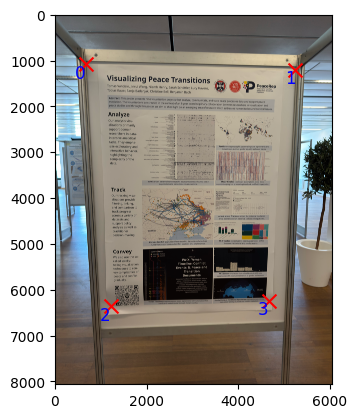

In [24]:
img = imgs[1]
res = image_doc_handler(img)
img_dat = cv2.imread(img)
src=np.array([
    res[0]["bbox"]["tl"],
    res[0]["bbox"]["tr"],
    res[0]["bbox"]["bl"],
    res[0]["bbox"]["br"],
])
# src = np.array([list(p) for p in res[0]["bbox"].values()])
dst = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
    ]
)
shape = np.flip(img_dat.shape[:2])
src = src * shape
dst_scaled = find_dest_doc(src)
src_flipped_y = np.copy(src)
src_flipped_y[:, 1] = shape[1] - src[:, 1]
plt.imshow(cv2.cvtColor(img_dat, cv2.COLOR_BGR2RGB))
plt.scatter(src_flipped_y[:, 0], src_flipped_y[:, 1], marker="x", color="red", s=100)
for i, (x, y) in enumerate(src_flipped_y):
    plt.text(x, y, str(i), color="blue", fontsize=12, ha="right", va="top")

In [25]:
dst_scaled

[[0, 0], [4579, 0], [0, 6553], [4579, 6553]]

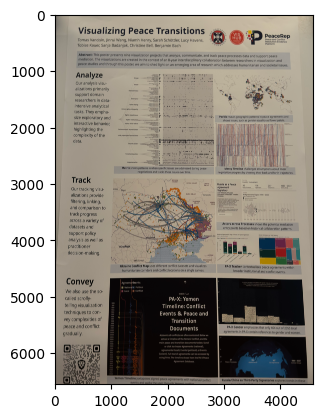

In [26]:
dst_mtx= np.array(dst_scaled).astype("float32")
src_mtx = np.array(src_flipped_y).astype("float32")
M = cv2.getPerspectiveTransform(src_mtx,dst_mtx)
dst_size=tuple(dst_mtx.max(axis=0).astype('int').tolist())

warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)
# warped_flipped=cv2.
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [27]:
dst_size

(4579, 6553)

In [41]:
def extract_poster_img(img: str):
    res = image_doc_handler(img)
    img_dat = cv2.imread(img)
    src = np.array([list(p) for p in res[0]["bbox"].values()])
    shape = np.flip(img_dat.shape[:2])
    src = src * shape
    dst_scaled = find_dest_doc(src)
    src_flipped_y = np.copy(src)
    src_flipped_y[:, 1] = shape[1] - src[:, 1]

    dst_mtx= np.array(dst_scaled).astype("float32")
    src_mtx = np.array(src_flipped_y).astype("float32")
    M = cv2.getPerspectiveTransform(src_mtx,dst_mtx)
    dst_size=tuple(dst_mtx.max(axis=0).astype('int').tolist())

    warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)

    return warped


for img in tqdm(imgs):
    img_path = Path(img)
    warped = extract_poster_img(img)
    target_path = img_path.parent.parent / "warped" / img_path.parts[-1]

    cv2.imwrite(str(target_path), warped)

100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


In [42]:
def authors_text(texts):
    results = texts
    for textbox in results:
        commas = (
            textbox[0].count(",")
            + textbox[0].count("and")
            + textbox[0].count("&")
            + textbox[0].count(".")
        )

        textbox.append(commas)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""


def biggest_text(texts):
    results = texts
    for textbox in results:
        dims = textbox[2]
        poss = np.array([dims["tl"], dims["tr"], dims["br"], dims["bl"]]).astype(
            np.float32
        )
        area = cv2.contourArea(poss)
        textbox.append(area)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""

In [49]:
outs = glob("figures/posters/warped/*.png")
for img in tqdm(outs):
    img_dat = cv2.imread(img)
    # downscale image
    dim_limit = 1080
    max_dim = max(img_dat.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img_dat = cv2.resize(img_dat, None, fx=resize_scale, fy=resize_scale)
    cv2.imwrite("figures/posters/reduced/" + img.split("/")[-1], img_dat)

100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


In [50]:
data = []

for img in tqdm(outs):
    texts = image_to_text(img, "eng")
    title = biggest_text(texts)
    authors = authors_text(texts)

    # print(title, authors)
    data.append(
        {
            "title": title,
            "authors": authors,
            "texts": texts,
            "img": img,
            "img_reduced": Path(img).parent.parent / "reduced" / Path(img).parts[-1],
        }
    )

100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


In [51]:
data_df=pd.DataFrame(data)
data_df

,title,authors,texts,img,img_reduced
0,"Focusing on small-scale public space design, t...",spatial development and impacts of ICT on phys...,[[spatial development and impacts of ICT on ph...,figures/posters/warped/IMG_5232.png,figures/posters/reduced/IMG_5232.png
1,Visualizing Peace Transitions,"Tomas Vancisin, Jinrui Wang, Niamh Henry, Sara...","[[Tomas Vancisin, Jinrui Wang, Niamh Henry, Sa...",figures/posters/warped/IMG_5233.png,figures/posters/reduced/IMG_5233.png
2,• Gradient estimations: optimization process u...,"|11 Steven Gogaclin, Jasspo Al. Flyon, Wesley ...","[[|11 Steven Gogaclin, Jasspo Al. Flyon, Wesle...",figures/posters/warped/IMG_5225.png,figures/posters/reduced/IMG_5225.png
3,SkyBrowser: In-situ Dissemination of Deep Spac...,"simultaneously, making mission capabilities ea...","[[simultaneously, making mission capabilities ...",figures/posters/warped/IMG_5231.png,figures/posters/reduced/IMG_5231.png
4,in PoS Blockchain Governance via Visual Analyt...,"*jenilove0517, *wouklee22, *hjha0508, §godnjs2...","[[*jenilove0517, *wouklee22, *hjha0508, §godnj...",figures/posters/warped/IMG_5234.png,figures/posters/reduced/IMG_5234.png


In [52]:
data_df["url"] = ""
data_df["abstract"] = ""

In [53]:
df_papers

,title,authors
0,BELT: Expert-in-the-Loop Validation of ML-Base...,"Gabriela Morgenshtern, Barbara Schlaepfer, Ve..."
1,Toward Supporting Narrative-Driven Data Explor...,Oliver Huang & Carolina Nobre
2,Data Analysis Across Boundaries,"Areeba Arif, Samah Daniyal, Zainab Haider, Mo..."
3,Scaling Human-AI Quality Control in Semiconduc...,"Kuhyun Lee, Jihoon Hong, Beomseok Kim, Yuna S..."
4,Summarizing Classed Region Maps with a Disk Ch...,"Steven van den Broek, Wouter Meulemans, Andre..."
...,...,...
90,PCAlloy: An Interactive Visualization Tool for...,Tommy Dang
91,AlloyClusterVis: An Interactive Visualization ...,Tommy Dang
92,Scrap Metal Explorer: Visual Exploration of Ma...,Tobias Maximilian & Andreas Nickel
93,A Comprehensive Visualization Tool for Sustain...,Lars Linsen


In [58]:
for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    title = row["title"]
    authors = row["authors"]
    k_nn=1
    
    result_dist, result_idx = nn.kneighbors(
        tfidf.transform([title + " " + authors])
    )
    result=df_papers.iloc[result_idx[0]]
    
    # data_df.loc[i, "url"] = result["link"].values[0]
    data_df.loc[i, "title"] = result["title"].values[0]
    data_df.loc[i, "authors"] = result["authors"].values[0]
    
    # data_df.loc[i, "abstract"] = result["abstract"].values[0]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 185.56it/s]


In [59]:
data_df

,title,authors,texts,img,img_reduced,url,abstract
0,Visualization on Smart Wristbands: Results fro...,"Alaul Islam, Fairouz Grioui, Raimund Dachselt...",[[spatial development and impacts of ICT on ph...,figures/posters/warped/IMG_5232.png,figures/posters/reduced/IMG_5232.png,,
1,Visualizing Peace Transitions: Interactive Vis...,"Tomas Vancisin, Jinrui Wang, Niamh Henry, Sar...","[[Tomas Vancisin, Jinrui Wang, Niamh Henry, Sa...",figures/posters/warped/IMG_5233.png,figures/posters/reduced/IMG_5233.png,,
2,Vis-FAB: Visual Analytics Framework for Wafer ...,Sugyeong Lee & Dong-Hee Lee,"[[|11 Steven Gogaclin, Jasspo Al. Flyon, Wesle...",figures/posters/warped/IMG_5225.png,figures/posters/reduced/IMG_5225.png,,
3,SkyBrowser: In-situ dissemination of high-reso...,"Ylva Selling, Ester Lindgren, Anders Ynnerman...","[[simultaneously, making mission capabilities ...",figures/posters/warped/IMG_5231.png,figures/posters/reduced/IMG_5231.png,,
4,Identifying Validator Alliances by Voting Simi...,Voting Similarity in PoS Blockchain Governanc...,"[[*jenilove0517, *wouklee22, *hjha0508, §godnj...",figures/posters/warped/IMG_5234.png,figures/posters/reduced/IMG_5234.png,,


In [ ]:
%pip install -U pylatex

Note: you may need to restart the kernel to use updated packages.


In [60]:
from pylatex.utils import escape_latex

In [63]:
with open("./posters.md", "w") as f:
    f.write("| **Poster** | **Title** | **Information** | \n")
    separator="| -- | -- | -- | \n"
    f.write(separator)
    lines=[
        f'| ![poster](figures/posters/reduced/{poster["img"].split("/")[-1]}) | {poster["title"].replace("|", " ")} | *{escape_latex(poster["authors"].replace("|", " "))}* | \n' for i,poster in data_df.iterrows()
    ]
    f.write("".join(lines))
    